# Data Description

This dataset provides the history of daily prices of Microsoft Stock (MSFT). All the column descriptions are provided. Currency is USD.
This dataset cointains informations from 01.01.2019 till 11.04.2024.

**Feature Description**

*Date*: This column represents the date of the trading day. Each row corresponds to the data for a specific trading day.

*Open*: The price at which the stock first traded when the market opened on the given date.

*High*: The highest price at which the stock traded during the trading day.

*Low*: The lowest price at which the stock traded during the trading day.

*Close*: The price at which the stock last traded when the market closed on the given date.

*Adjusted Close*: The closing price adjusted for any corporate actions, such as dividends or stock splits, that occurred on the given date. This is often considered a more accurate reflection of the stock's true value.

*Volume*: The total number of shares of the stock that were traded during the trading day.

In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import keras

import yfinance as yf
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from keras.callbacks import EarlyStopping

In [30]:
# Read Data
start = pd.to_datetime('2019.01.01')
end = datetime.now()

data = yf.download("MSFT", start = start , end = end)

[*********************100%%**********************]  1 of 1 completed


In [31]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,99.550003,101.750000,98.940002,101.120003,95.846016,35329300
2019-01-03,100.099998,100.190002,97.199997,97.400002,92.320030,42579100
2019-01-04,99.720001,102.510002,98.930000,101.930000,96.613762,44060600
2019-01-07,101.639999,103.269997,100.980003,102.059998,96.737000,35656100
2019-01-08,103.040001,103.970001,101.709999,102.800003,97.438400,31514400


In [32]:
# Info about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1328 entries, 2019-01-02 to 2024-04-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1328 non-null   float64
 1   High       1328 non-null   float64
 2   Low        1328 non-null   float64
 3   Close      1328 non-null   float64
 4   Adj Close  1328 non-null   float64
 5   Volume     1328 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 72.6 KB


In [33]:
# Statistic description
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1328.0,2.451651e+02,8.021753e+01,9.955000e+01,1.824250e+02,2.469050e+02,3.028750e+02,4.298300e+02
High,1328.0,2.476427e+02,8.079837e+01,1.001900e+02,1.841250e+02,2.498500e+02,3.052275e+02,4.308200e+02
Low,1328.0,2.426313e+02,7.956303e+01,9.720000e+01,1.800200e+02,2.447150e+02,2.999125e+02,4.271600e+02
Close,1328.0,2.452686e+02,8.022263e+01,9.740000e+01,1.817500e+02,2.475350e+02,3.021025e+02,4.293700e+02
Adj Close,1328.0,2.405951e+02,8.151456e+01,9.232003e+01,1.757836e+02,2.434675e+02,2.960309e+02,4.293700e+02
Volume,1328.0,2.903914e+07,1.224665e+07,2.911285e+06,2.141630e+07,2.607780e+07,3.312338e+07,9.701270e+07


In [34]:
# Checking for null/ missing values
print('Shape of data', data.shape)
print('Missing values:')
data.isna().sum()

Shape of data (1328, 6)
Missing values:


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

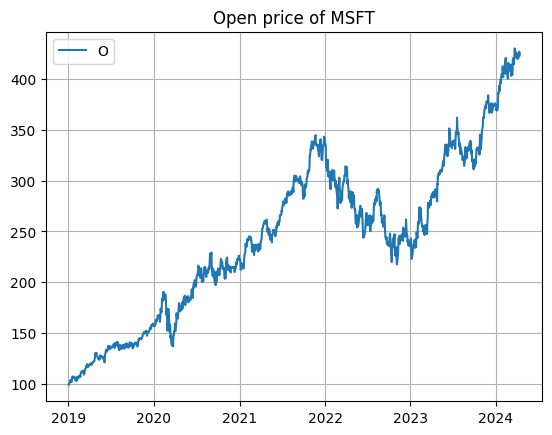

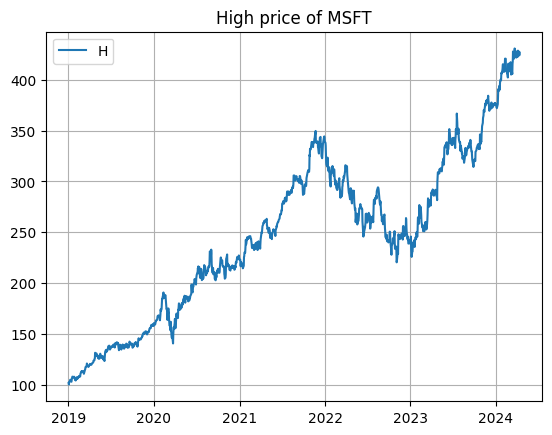

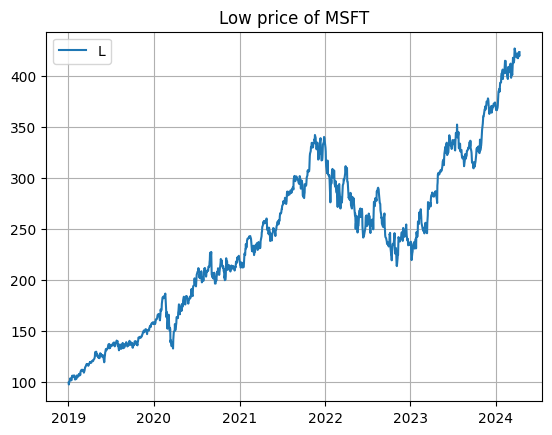

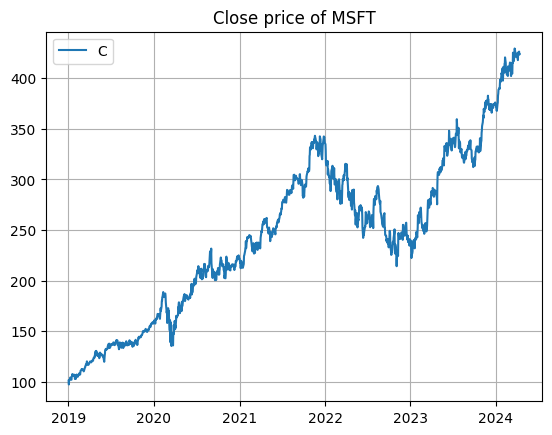

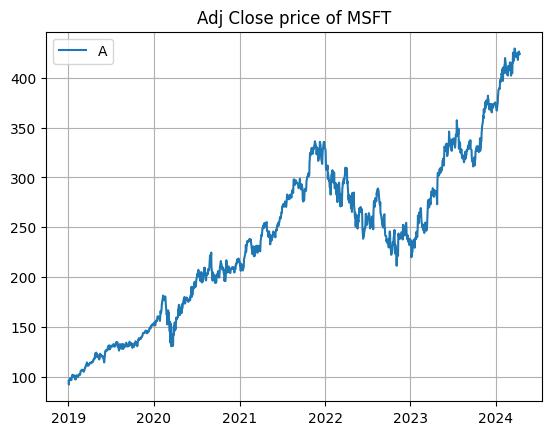

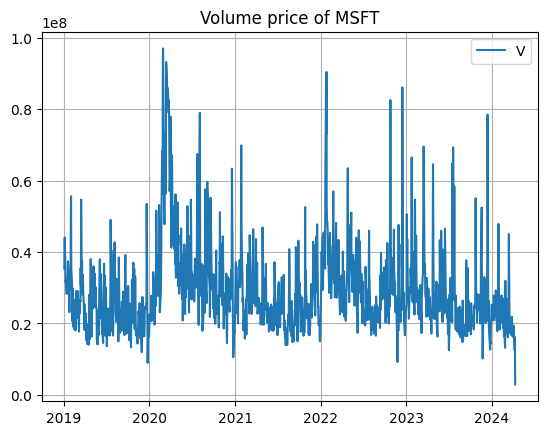

In [57]:
# Visualisations
col_names = ['Open', 'High', 'Low','Close','Adj Close', 'Volume']

for col,col_name in zip(data.columns, col_names):
  plt.plot(data[col], label = 'col_name')
  plt.legend(col_name)
  plt.title(f'{col_name} price of MSFT')
  plt.grid(True)
  plt.show()


------------------
I will use column Close for predictions

In [65]:
# I made dataframe that contains only Close column and than by using values i converted it to a numpy array
dataset = data.iloc[:,3:4].values
dataset[:5]

array([[101.12000275],
       [ 97.40000153],
       [101.93000031],
       [102.05999756],
       [102.80000305]])

In [130]:
# Creating dataset for training and testing
trainsize = int(0.8 * len(dataset))

training_data = dataset[:trainsize]
testing_data = dataset[trainsize:]

print('Shape of train data:', training_data.shape, 'Shape of test data:', testing_data.shape)

Shape of train data: (1062, 1) Shape of test data: (266, 1)


In [69]:
# Before Scaling
training_data[:2], testing_data[:2]

(array([[101.12000275],
        [ 97.40000153]]),
 array([[272.29000854],
        [277.66000366]]))

In [131]:
# Scaling data using MinMaxScaler --> will give values from 0 to 1
mms = MinMaxScaler(feature_range=(0,1))

training_data = mms.fit_transform(training_data)
testing_data = mms.transform(testing_data)

# After scaling
training_data[:2], testing_data[:2]

(array([[0.0151398],
        [0.       ]]),
 array([[0.71177412],
        [0.73362913]]))

In [174]:
# Split data into X and y
def split_data(dataset, timesteps):
  X = []
  y = []

  for i in range(timesteps, len(dataset)):
    X.append(dataset[i - timesteps:i,0])
    y.append(dataset[i,0])

  return np.array(X), np.array(y)


In [175]:
X_train, y_train = split_data(training_data, 60)
X_test, y_test = split_data(testing_data, 60)

print('Shapes of train:', X_train.shape,y_train.shape)
print('Shapes of test:', X_test.shape,y_test.shape)

Shapes of train: (1002, 60) (1002,)
Shapes of test: (206, 60) (206,)


In [176]:
# Reshape (n_samples,timesteps,n_features)
timesteps = 60

X_train = X_train.reshape(X_train.shape[0],timesteps,1)
X_test = X_test.reshape(X_test.shape[0],timesteps,1)

### It is time to build and train models. I will try using LSTM and GRU, and their combination.

In [177]:
# First i will create callbacks
# es = EarlyStopping(monitor = 'val_loss', patience = 3) # to stop if there is no improvement on loss

In [210]:
# Architecture
model_lstm = Sequential([
    LSTM(units = 100, activation = 'tanh', input_shape = (timesteps,1)),
    Dense(32, activation = 'relu'),
    Dropout(0.5),
    Dense(1)
])

# Model summary
model_lstm.summary()

# Compile model
model_lstm.compile(optimizer = 'adam', loss = 'mse')

# Model fit
history_lstm = model_lstm.fit(X_train,y_train, epochs = 10,
               batch_size = 32,
               validation_split=0.2)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 100)               40800     
                                                                 
 dense_55 (Dense)            (None, 32)                3232      
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_56 (Dense)            (None, 1)                 33        
                                                                 
Total params: 44065 (172.13 KB)
Trainable params: 44065 (172.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
26/26 [==============================] - 4s 67ms/step - loss: 0.0788 - val_loss: 0.0115
Epoch 2/10
26/26 [==============================

GRU

In [211]:
# Architecture
model_gru = Sequential([
    GRU(units = 100, activation = 'tanh', input_shape = (timesteps,1)),
    Dense(32, activation = 'relu'),
    Dropout(0.5),
    Dense(1)
])

# Model summary
model_gru.summary()

# Compile model
model_gru.compile(optimizer = 'adam', loss = 'mse')

# Model fit
history_gru = model_gru.fit(X_train,y_train, epochs = 10,
               batch_size = 32,
               validation_split=0.2)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 100)               30900     
                                                                 
 dense_57 (Dense)            (None, 32)                3232      
                                                                 
 dropout_25 (Dropout)        (None, 32)                0         
                                                                 
 dense_58 (Dense)            (None, 1)                 33        
                                                                 
Total params: 34165 (133.46 KB)
Trainable params: 34165 (133.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
26/26 [==============================] - 8s 86ms/step - loss: 0.0816 - val_loss: 0.0088
Epoch 2/10
26/26 [==============================

LSTM + GRU

In [212]:
# Architecture
model_stacked = Sequential([
    LSTM(units = 100, activation = 'tanh', input_shape = (timesteps,1),
         return_sequences = True),
    GRU(units = 100, activation = 'tanh'),
    Dense(32, activation = 'relu'),
    Dropout(0.5),
    Dense(1)
])

# Model summary
model_stacked.summary()

# Compile model
model_stacked.compile(optimizer = 'adam', loss = 'mse')

# Model fit
history_model_stacked = model_stacked.fit(X_train,y_train, epochs = 10,
               batch_size = 32,
               validation_split=0.2)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 60, 100)           40800     
                                                                 
 gru_15 (GRU)                (None, 100)               60600     
                                                                 
 dense_59 (Dense)            (None, 32)                3232      
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                                 
 dense_60 (Dense)            (None, 1)                 33        
                                                                 
Total params: 104665 (408.85 KB)
Trainable params: 104665 (408.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
26

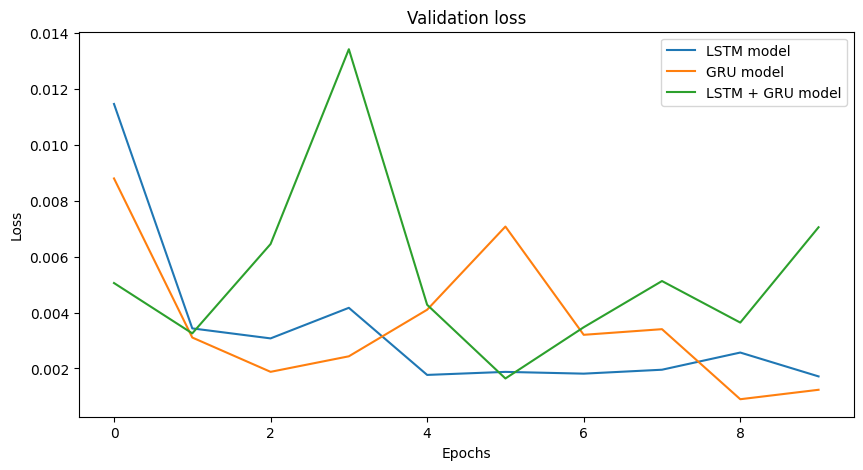

In [213]:
# Plotting history of models
plt.figure(figsize = (10,5))

plt.plot(history_lstm.history['val_loss'],
         label = 'LSTM model')
plt.plot(history_gru.history['val_loss'],
         label = 'GRU model')
plt.plot(history_model_stacked.history['val_loss'],
         label = 'LSTM + GRU model')

plt.legend()
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Prediction

In [214]:
print('Predictions with LSTM model')
predict_lstm = model_lstm.predict(X_test)
predict_lstm = mms.inverse_transform(predict_lstm)

print('Predictions with GRU model')
predict_gru = model_gru.predict(X_test)
predict_gru = mms.inverse_transform(predict_gru)

print('Predictions with LSTM+GRU model')
predict_stacked = model_stacked.predict(X_test)
predict_stacked = mms.inverse_transform(predict_stacked)

Predictions with LSTM model
7/7 [==============================] - 1s 17ms/step
Predictions with GRU model
7/7 [==============================] - 1s 14ms/step
Predictions with LSTM+GRU model
7/7 [==============================] - 1s 28ms/step


In [215]:
# Scores
from sklearn.metrics import mean_squared_error
print('RMSE with LSTM model:', np.sqrt(mean_squared_error(y_test,predict_lstm)))
print('RMSE with GRU model:', np.sqrt(mean_squared_error(y_test,predict_gru)))
print('RMSE with LSTM+GRU model:', np.sqrt(mean_squared_error(y_test,predict_stacked)))


RMSE with LSTM model: 351.07729903159054
RMSE with GRU model: 351.97242088186823
RMSE with LSTM+GRU model: 326.2164065570264


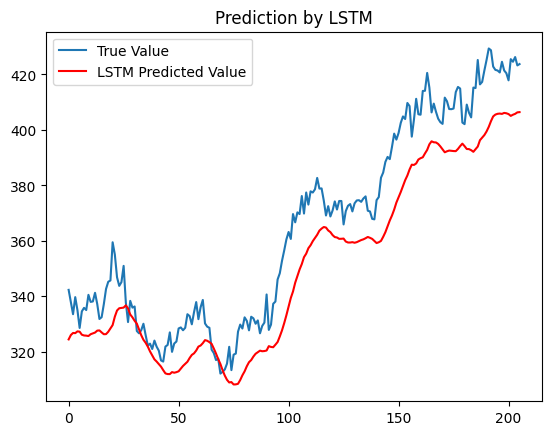

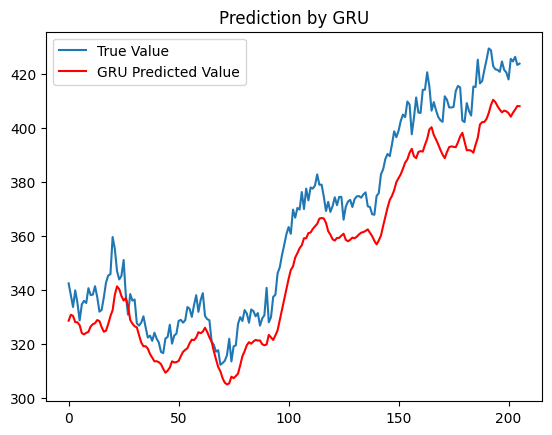

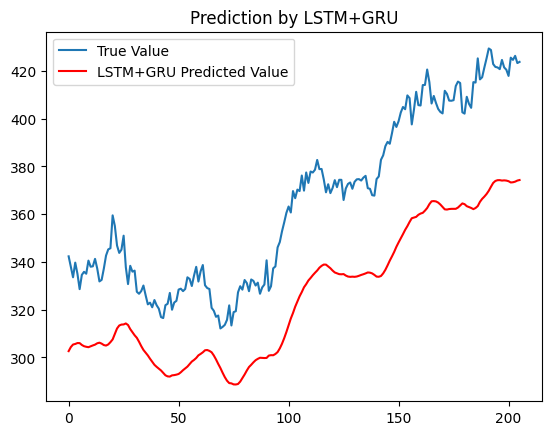

In [216]:
#Predicted vs True
predictions = [predict_lstm,predict_gru, predict_stacked]
model_names = ['LSTM', 'GRU', 'LSTM+GRU']

for model_name, prediction in zip(model_names,predictions):
  plt.plot(mms.inverse_transform(y_test.reshape(-1,1)), label='True Value')
  plt.plot(prediction, label=f'{model_name} Predicted Value', color = 'red')
  plt.title(f'Prediction by {model_name}')
  plt.legend()
  plt.show()

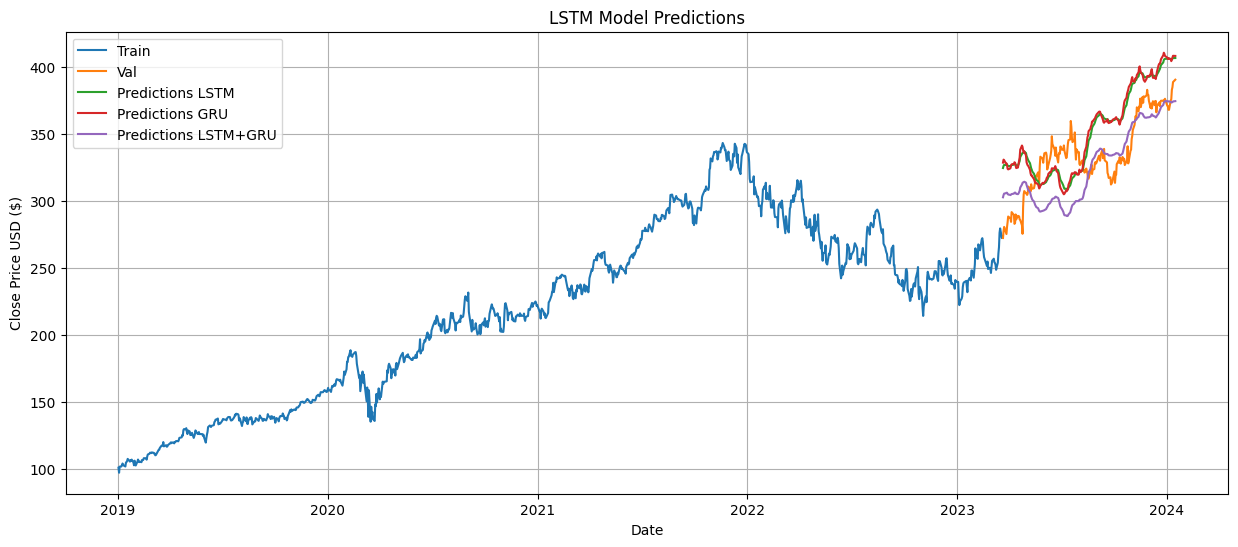

In [217]:
# Prediction
train = data[:trainsize]
valid = data.iloc[:,3:4][trainsize :]
valid = valid[:len(predict_lstm)]
valid['Predictions_LSTM'] = predict_lstm
valid['Predictions_GRU'] = predict_gru
valid['Predictions_LSTM+GRU'] = predict_stacked


# Visualize the data
plt.figure(figsize=(15,6))
plt.title('LSTM Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions_LSTM']])
plt.plot(valid[['Predictions_GRU']])
plt.plot(valid[['Predictions_LSTM+GRU']])
plt.legend(['Train', 'Val', 'Predictions LSTM','Predictions GRU', 'Predictions LSTM+GRU'], loc='upper left')
plt.grid()
plt.show()

In [218]:
valid

,Close,Predictions_LSTM,Predictions_GRU,Predictions_LSTM+GRU
Date,,,,
2023-03-22,272.290009,324.464203,328.476898,302.639465
2023-03-23,277.660004,326.034149,330.695404,304.343628
2023-03-24,280.570007,326.792511,330.245331,305.397369
2023-03-27,276.380005,326.720947,327.931702,305.640076
2023-03-28,275.230011,327.364746,327.894470,306.022522
...,...,...,...,...
2024-01-09,375.790009,405.063782,404.087067,373.265564
2024-01-10,382.769989,405.486664,405.535156,373.351746
2024-01-11,384.630005,405.797516,406.735596,373.607330


# Summary

Not the best results and predictions. But this was just the simpliest approach for predicting stock prices.
There's a lot that can be done to make better performance and predictions.